In [182]:
# import
import numpy as np
import tensor.tensor_product_wrapper as tp
from utils.plotting_utils import montage_array, slice_subplots
import matplotlib.pyplot as plt
import similarity_metrics as sm
from sklearn.model_selection import train_test_split
import scipy.io
import utils.starplus_utils as starp
from numpy.linalg import norm
from tensor.utils import assert_compatile_sizes_modek, reshape, make_axis_iterable
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from matplotlib.cm import ScalarMappable
from numpy.linalg import svd
from tensor.mode_k import modek_unfold
from sklearn.utils.extmath import randomized_svd
from scipy.stats import ortho_group

In [183]:
# ==================================================================================================================== #
# choose product type {'f', 't', 'c'，'m'}
# m-product using haarMatrix
prod_type = 'm'

In [184]:
# ==================================================================================================================== #
# define projection
def projection(A, U, prod_type):
    if prod_type == 'm':
        # Banded Matrix
        # training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type,M = (New_M_Matrix(64,8),New_M_Matrix(8,2),New_M_Matrix(16,3)))
        # return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (New_M_Matrix(64,8),New_M_Matrix(8,2),New_M_Matrix(16,3)))
        # Haar Matrix
        # training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
        # return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
        # Data Dependent Matrix
        # u1, _,_ = randomized_svd(modek_unfold(training_data[:, :, :, :, :],2), n_components=64, n_iter=5, random_state=20)
        # u2,_,_ = randomized_svd(modek_unfold(training_data[:, :, :, :, :],3), n_components=8, n_iter=5, random_state=20)
        # u3,_,_ = randomized_svd(modek_unfold(training_data[:, :, :, :, :],4), n_components=16, n_iter=5, random_state=20)
        # training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type, M = (u1,u2,u3))
        # return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (u1,u2,u3))
        # Random Orthogonal Matrix
        training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type,M = (ortho_group.rvs(64),ortho_group.rvs(8),ortho_group.rvs(16)))
        return tp.ten_prod(U, training_coeff, prod_type=prod_type, M = (ortho_group.rvs(64),ortho_group.rvs(8),ortho_group.rvs(16)))
    else:
        training_coeff = tp.ten_prod(tp.ten_tran(U, prod_type=prod_type), A, prod_type=prod_type)
        return tp.ten_prod(U, training_coeff, prod_type=prod_type) 

In [185]:
# ==================================================================================================================== #
# for reproducibility
np.random.seed(20)

In [186]:
# load data
# we need the variables
#   training_data, training_labels, test_data, test_labels, num_classes
num_classes = 2
star_plus_data = scipy.io.loadmat('data-starplus-04847-v7.mat')
tensor_PS, labels = starp.get_labels(star_plus_data)
tensor_PS  = tensor_PS / norm(tensor_PS)

In [187]:
print(np.transpose(labels).shape)
print(np.moveaxis(tensor_PS, -1, 0).shape)
training_data, test_data, training_labels, test_labels = train_test_split(np.moveaxis(tensor_PS, -1, 0), np.transpose(labels), test_size=0.33, random_state=42)
print(training_data.shape)
(unique, counts) = np.unique(test_labels, return_counts=True)
print(unique)
print(counts)
(unique, counts) = np.unique(training_labels, return_counts=True)
print(unique)
print(counts)

(80, 1)
(80, 64, 64, 8, 16)
(53, 64, 64, 8, 16)
[0. 1.]
[14 13]
[0. 1.]
[26 27]


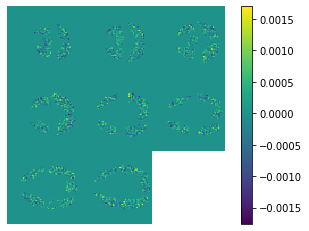

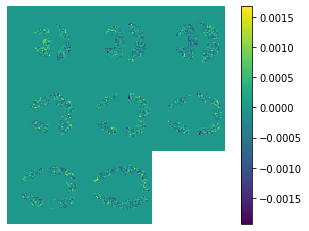

In [188]:
# visualize data
# use the existing tools or write your own!
plt.figure(1)
montage_array(training_data[0, :, :, :, 0], cmap='viridis')
plt.show()
plt.figure(2)
montage_array(test_data[0, :, :, :, 0], cmap='viridis')
plt.show()

In [189]:
# move the label number to second axis
training_data = np.moveaxis(training_data, 0, 1)
test_data = np.moveaxis(test_data, 0, 1)
print(training_data.shape)
print(test_data.shape)

(64, 53, 64, 8, 16)
(64, 27, 64, 8, 16)


In [190]:
# create the boolean array for training and testing
boolean_list = []
for i in (training_labels):
    boolean_list.append(i[0])
boolean_array_training = np.asarray(boolean_list)
print(boolean_array_training)

boolean_list = []
for i in (test_labels):
    boolean_list.append(i[0])
boolean_array_testing = np.asarray(boolean_list)
print(boolean_array_testing)

[1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1.
 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 1. 1. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1.
 0. 1. 1.]


In [191]:
# HaarMatrix utilized for m-product
def haarMatrix(n):
    # n is the power of 2
    if n > 2:
        M = haarMatrix(n / 2)
    else:
        return np.array([[1, 1], [1, -1]])
    M_n = np.kron(M, [1, 1])
    M_i = np.sqrt(n/2)*np.kron(np.eye(len(M)), [1, -1])
    M = np.vstack((M_n, M_i))
    return M
def haar_normalized(n):
    M = haarMatrix(n)
    M = M/np.sqrt(np.sum(M[0]))
    return M

In [192]:
def New_M_Matrix(dimension,bandwidth):
    A = np.eye(dimension)
    for i in range(0, -bandwidth, -1):
        A += np.eye(dimension, k = i -1)
    for i in range(dimension):
        temp = np.sum(A[i])
        for k in range(dimension):
            if A[i][k] == 1:
                A[i][k] = 1/temp
    return A

In [193]:
# ==================================================================================================================== #
# form local t-svd
# num_class should be 2
num_classes = len(np.unique(training_labels))
k = 5

U = []
print(num_classes)

for i in range(num_classes):
    if prod_type == 'm':
        # Bandwidth Matrix
        # u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type, M = (New_M_Matrix(64,8),New_M_Matrix(8,2),New_M_Matrix(16,3)))
        # Haar Matrix
        # u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type, M = (haar_normalized(64),haar_normalized(8),haar_normalized(16)))
        # Data Dependent Matrix
        # u1, _,_ = randomized_svd(modek_unfold(training_data[:, :, :, :, :],2), n_components=64, n_iter=5, random_state=20)
        # u2,_,_ = randomized_svd(modek_unfold(training_data[:, :, :, :, :],3), n_components=8, n_iter=5, random_state=20)
        # u3,_,_ = randomized_svd(modek_unfold(training_data[:, :, :, :, :],4), n_components=16, n_iter=5, random_state=20)
        # u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type, M = (u1,u2,u3))
        # Random Orthogonal Matrix
        u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type, M = (ortho_group.rvs(64),ortho_group.rvs(8),ortho_group.rvs(16)))
        U.append(u)
    else:
        u, _, _, _ = tp.ten_svd(training_data[:, boolean_array_training == i, :], k, prod_type=prod_type)
        U.append(u)

2


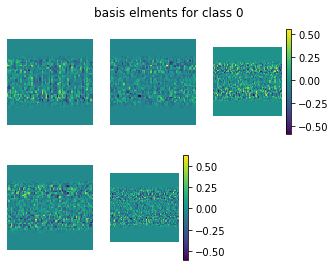

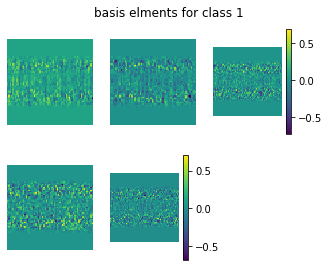

In [194]:
# visualizations
# use the existing tools or write your own!
for i in range(num_classes):
    slice_subplots(U[i][:, :, :, 0, 0], axis=1, title='basis elments for class ' + str(i))
    plt.show()

train accuracy = 32.08
test accuracy = 62.96


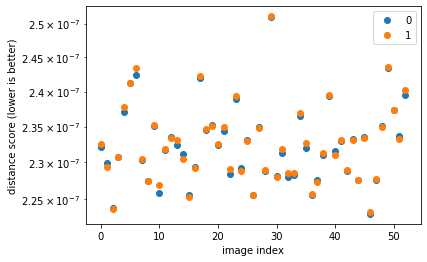

In [195]:
# ==================================================================================================================== #
# compute results on training and test data
training_error = np.zeros([num_classes, training_data.shape[1]])
test_error = np.zeros([num_classes, test_data.shape[1]])
for i in range(num_classes):
    training_projection = projection(training_data, U[i], prod_type=prod_type)
    training_error[i, :] = sm.frobenius_metric(training_data, training_projection, axis=1)

    test_projection = projection(test_data, U[i], prod_type=prod_type)
    test_error[i, :] = sm.frobenius_metric(test_data, test_projection, axis=1)


# classification
training_predicted_classes = np.argmin(training_error, axis=0).reshape(-1)
test_predicted_classes = np.argmin(test_error, axis=0).reshape(-1)

# results

training_num_correct = np.sum(training_predicted_classes == boolean_array_training)
training_accuracy = training_num_correct / training_data.shape[1]

test_num_correct = np.sum(test_predicted_classes == boolean_array_testing)
test_accuracy = test_num_correct / test_data.shape[1]

print('train accuracy = %0.2f' % (100 * training_accuracy))
print('test accuracy = %0.2f' % (100 * test_accuracy))

# plot results
plt.figure()
for i in range(num_classes):
    plt.semilogy(training_error[i, :], 'o', label=i)

plt.xlabel('image index')
plt.ylabel('distance score (lower is better)')
plt.legend()
plt.show()

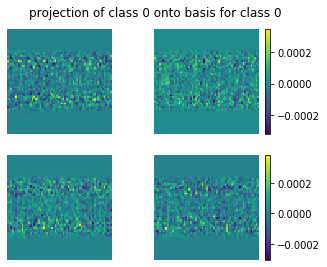

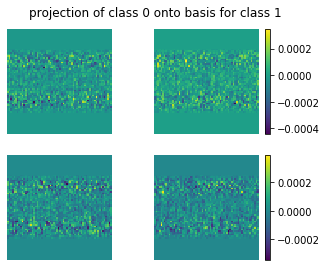

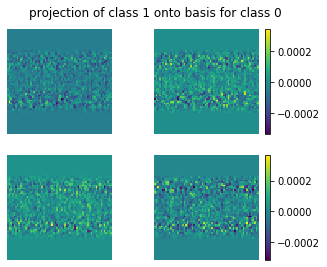

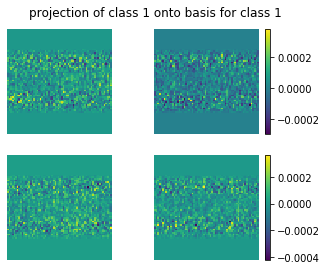

In [196]:
# ==================================================================================================================== #
# visualizations of projected tensors
# use the existing tools or write your own!

for j in range(num_classes):
    for i in range(num_classes):
        A = projection(training_data[:,boolean_array_training == j,:], U[i], prod_type=prod_type)
        slice_subplots(A[:, :4, :,0,0], axis=1, title='projection of class ' + str(j) + ' onto basis for class ' + str(i))
        plt.show()